<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/IR_7classes_Unet_Final_Visualize_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print("keras version is", tf.keras.__version__)
print ("tf version is", tf.__version__) 
!python --version

keras version is 2.6.0
tf version is 2.6.0
Python 3.7.12


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#!cd "drive/My Drive/PhD/IRLabeledDataset"

Mounted at /content/drive


In [ ]:
# to empty a folder from google drive 
dir_id = "1wPVVzty0hASJfBbV5hzjEjYPsShJF6mi"
file_id = "avoid deleting this file"

service.files().update(fileId=file_id, addParents="root", removeParents=dir_id).execute()
service.files().delete(fileId=dir_id).execute()

In [3]:
import os
import numpy as np
import cv2

input_dir = "/content/drive/MyDrive/IRImages_7classes_unet" # directory containing 8000 IR input images
target_dir = "/content/drive/MyDrive/IRImages_7classes_masks_unet" # directory containing 8000 segmented IR images

img_size = (256, 320) #it's height and width. it's a 1/2 sized image from the original image from segment.ai
num_classes = 7
batch_size = 10

# check for distinct label values in all masked files 

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

#prints how many files are in the batch
print("Number of samples:", len(input_img_paths))
print("Number of samples:", len(target_img_paths))

#prints the name of 10 sets of input and labeled file
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)



Number of samples: 8874
Number of samples: 8874
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_31.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_31.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_32.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_32.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_33.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_33.png
/content/drive/MyDrive/IRImages_7classes_unet/1571161174.581624_1_2_34.png | /content/drive/MyDrive/IRImages_7classes_masks_unet/1571161174.581624_1_2_34.png
/content/drive/MyDri

In [ ]:
import cv2
import tensorflow
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import PIL

#val_input_img_paths_test = ['/content/drive/MyDrive/IRImages_7classes_unet/1571161440.714693_1_2_31.png']
#val_target_img_paths_test = ['/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2_31.png']

img = cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2_31.png')
print(img) 
img1 = cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2_31.png', cv2.IMREAD_UNCHANGED)
print(img1)
print(img.shape) # height , width, color
print(img1.shape)
array1 = tensorflow.keras.preprocessing.image.img_to_array(img)
print(array1) 
array2 = tensorflow.keras.preprocessing.image.img_to_array(img1)
print(array2) 
print(np.unique(array1))
print(np.unique(array2))
print(tensorflow.keras.backend.epsilon())
print(np.unique(cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2_31.png')))
print(np.unique(cv2.imread('/content/drive/MyDrive/IRImages_7classes_masks_unet/1571161440.714693_1_2_31.png',cv2.IMREAD_UNCHANGED)))

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            #in case we want to see if masked image have the right values
            #print(tensorflow.keras.preprocessing.image.img_to_array(img))
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2: 
            #if classes are 3, keras expects masked values to be 0,1,2 only. Cannot take 1,3,5. It checks numerically not just the number of masked values
            #y[j] += 1 
        return x, y


In [5]:
import random

# Split our img paths into a training and a validation set. There are 8000 images in the input. 
val_samples = 500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

this is the raw image


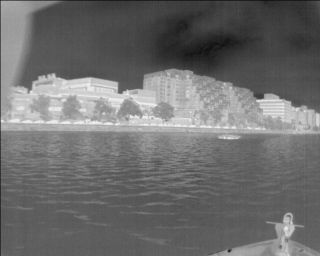

this is the labeled image


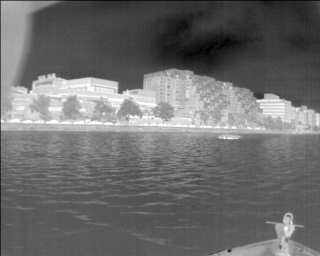

(256, 320, 1)
1
320
<class 'PixelAccess'>
(0, 0, 0)
this is the colored inferred image


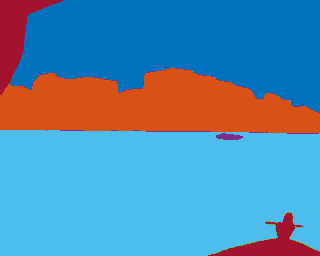

this is the gray inferred image


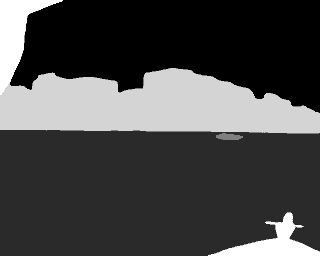

In [8]:
# Generate predictions for all images in the validation set

from IPython.display import Image, display
import PIL
from PIL import ImageOps
#from PIL import Image

#val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_input_img_paths_test = ['/content/drive/MyDrive/poorlighting_brightlight_resized/1603208980.690948_resized.png']
val_input_img_paths_test = ['/content/drive/MyDrive/Inferences/1603208961.571033_1.png']
val_target_img_paths_test = ['/content/drive/MyDrive/Inferences/1603208961.571033_1.png']


#print(type(val_input_img_paths_test))

val_gen = OxfordPets(1, img_size, val_input_img_paths_test, val_target_img_paths_test)
# we will use model for the 1st run. and then reconstructed_model from run 2
#val_preds = model.predict(val_gen)

#predict using the saved model - run 2 on 
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/UNet_7classes_1.0")
val_preds = reconstructed_model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction. we need color masked images, so displaying both color and black and white"""
    #label_colours = [(59,193,246), (222,168,51), (161,78,69), (177, 168, 52), (238, 159, 231), (240, 244, 74), (160, 253, 134)]  
    #label_colours = [(246,193,59), (51,168,222), (69,78,161), (52, 168, 177), (231, 159, 238), (74, 244, 240), (134, 253, 160)]  
    #                0 - sky(d.blue). 1 - water(l.blue).   2 - bridge(yellow).   3 - obstacle(purple).  4- living ob(green).  
    #                5- backgnd (orange). 6 - self(pink)
    label_colours = [(0,113,188), (76,189,237), (236,176,31), (125, 46, 141), (118, 171, 47), (216, 82, 24), (161, 19, 46)]  
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    print(np.shape(mask))
    print(len(mask[i, 0]))
    print(len(mask[i]))

    img1 = PIL.Image.new('RGB', (320, 256))
    pixels = img1.load()
    print(type(pixels))
    print(pixels[0,0])
    for j_, j in enumerate(mask[:, :, 0]):
        #print (j_, j)
        for k_, k in enumerate(j):
              #print(k_, k)
              if k < num_classes:
                  pixels[k_,j_] = label_colours[k]
    output = np.array(img1)
    
    print("this is the colored inferred image")
    display(img1)
  

    print("this is the gray inferred image")
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #40. it uses val_inpit_images. so will only pick from the ones that we have kept for validation.
i = 0

# Display input image
print("this is the raw image")
display(Image(filename=val_input_img_paths_test[i]))

# Display ground-truth target mask
print("this is the labeled image")
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths_test[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.